In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [3]:
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten,BatchNormalization, Activation, Dropout
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


2025-07-30 04:40:04.866985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753850405.241804      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753850405.352267      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
os.listdir('/kaggle/input/plantdisease/PlantVillage')

['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 25,
    validation_split = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
valid_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

train_dataset = train_datagen.flow_from_directory(
    '/kaggle/input/plantdisease/PlantVillage',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training',
    seed = 42
)
valid_dataset = valid_datagen.flow_from_directory(
    '/kaggle/input/plantdisease/PlantVillage',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'validation',
    seed = 42
)
train_dataset.class_indices

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

In [6]:
from keras.applications.vgg19 import VGG19

In [7]:
conv_base = VGG19(
    weights= None,
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1753850440.657737      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753850440.658440      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [9]:
conv_base.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 9,439,232 (36.01 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [10]:
model_vgg = Sequential()

model_vgg.add(conv_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(512,activation='relu'))
model_vgg.add(Dense(512,activation='relu'))
model_vgg.add(Dense(15,activation='softmax'))

In [11]:
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,140,303 (126.42 MB)

 Trainable params: 22,555,151 (86.04 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [12]:
model_vgg.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=["accuracy"])

In [13]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min')

history = model_vgg.fit(train_dataset, validation_data=valid_dataset, epochs=10, callbacks=[earlystopping, learning_rate, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1753850448.174905     122 service.cc:148] XLA service 0x7eb170007910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753850448.176544     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753850448.176566     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753850448.811397     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753850462.046236     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/517 ━━━━━━━━━━━━━━━━━━━━ 370s 682ms/step - accuracy: 0.1893 - loss: 2.4471 - val_accuracy: 0.3552 - val_loss: 1.8762 - learning_rate: 0.0010
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 234s 452ms/step - accuracy: 0.3947 - loss: 1.8060 - val_accuracy: 0.4119 - val_loss: 1.8279 - learning_rate: 0.0010
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 443ms/step - accuracy: 0.4723 - loss: 1.6081 - val_accuracy: 0.4294 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 228s 440ms/step - accuracy: 0.5095 - loss: 1.4738 - val_accuracy: 0.5449 - val_loss: 1.4111 - learning_rate: 0.0010
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 235s 454ms/step - accuracy: 0.5294 - loss: 1.4124 - val_accuracy: 0.4483 - val_loss: 1.6969 - learning_rate: 0.0010
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 231s 447ms/step - accuracy: 0.5535 - loss: 1.3429 - val_accuracy: 0.5505 - val_loss: 1.3966 - learning_rate: 0.0010
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 226s 436ms/step - accuracy: 0.5810 

**Increasing epoch**

In [15]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min')

history = model_vgg.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[earlystopping, learning_rate, checkpoint])

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 235s 454ms/step - accuracy: 0.6560 - loss: 1.0205 - val_accuracy: 0.6752 - val_loss: 0.9521 - learning_rate: 0.0010
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 230s 444ms/step - accuracy: 0.6839 - loss: 0.9286 - val_accuracy: 0.6477 - val_loss: 1.0786 - learning_rate: 0.0010
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 233s 451ms/step - accuracy: 0.7030 - loss: 0.8751 - val_accuracy: 0.6992 - val_loss: 0.8834 - learning_rate: 0.0010
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 246s 475ms/step - accuracy: 0.7141 - loss: 0.8280 - val_accuracy: 0.6582 - val_loss: 1.0809 - learning_rate: 0.0010
Epoch 5/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 241s 466ms/step - accuracy: 0.7340 - loss: 0.7801 - val_accuracy: 0.6963 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 6/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7271 - loss: 0.7915
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
517/517 ━━━━━━━━━━━━━━━━━━━━ 239s 462ms/step - accuracy:

In [16]:
history = model_vgg.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[earlystopping, learning_rate, checkpoint])

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 224s 434ms/step - accuracy: 0.7332 - loss: 0.7674 - val_accuracy: 0.7043 - val_loss: 0.9575 - learning_rate: 3.0000e-04
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 234s 452ms/step - accuracy: 0.7479 - loss: 0.7298 - val_accuracy: 0.7227 - val_loss: 0.8480 - learning_rate: 3.0000e-04
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 225s 435ms/step - accuracy: 0.7602 - loss: 0.7041 - val_accuracy: 0.6815 - val_loss: 1.0362 - learning_rate: 3.0000e-04
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 225s 434ms/step - accuracy: 0.7581 - loss: 0.6858 - val_accuracy: 0.6773 - val_loss: 1.0832 - learning_rate: 3.0000e-04
Epoch 5/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7703 - loss: 0.6656
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
517/517 ━━━━━━━━━━━━━━━━━━━━ 226s 437ms/step - accuracy: 0.7703 - loss: 0.6656 - val_accuracy: 0.6793 - val_loss: 1.0317 - learning_rate: 3.0000e-04
Epoch 6/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 222s 42

In [18]:
model_vgg.save('Vgg19base.h5')

In [65]:
model = tf.keras.models.load_model('Vgg19base.h5')
# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(valid_dataset, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.7152 - loss: 0.8592
Test Loss: 0.8480
Test Accuracy: 0.7227


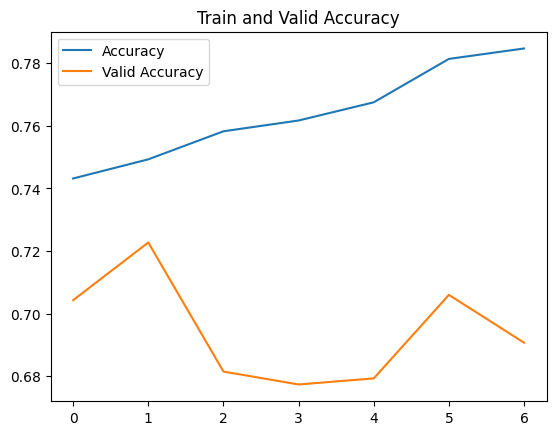

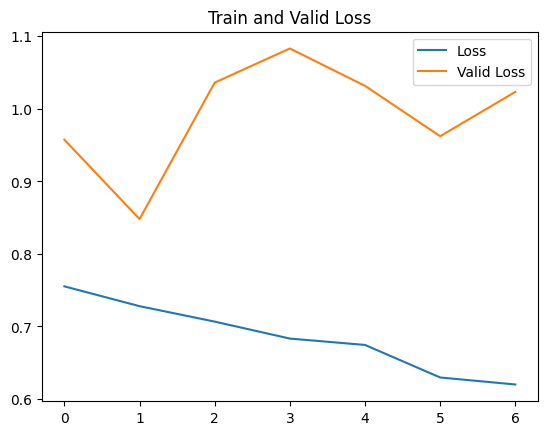

In [19]:
plt.figure()
plt.title('Train and Valid Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Valid Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


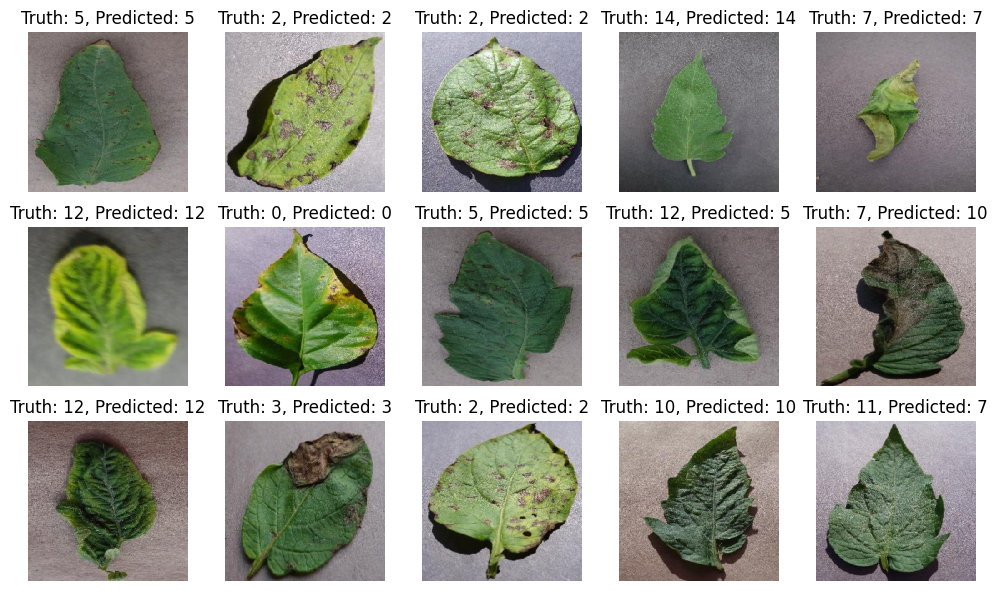

In [21]:
images, labels = next(valid_dataset)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img = images[i]
    image = img_to_array(img)
    image = tf.expand_dims(image, axis=0)
    label = np.argmax(labels[i])
    predict = model_vgg.predict(image)[0].argmax()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Truth: {label}, Predicted: {predict}')

plt.tight_layout()
plt.show()

## 📌 Model Architecture Explanation

### 🧠 Base Model: VGG19 (Custom Trained)

In this model, I utilized the **VGG19** architecture as a convolutional feature extractor, where:

* `weights=None`: This means the model **was not initialized with pretrained ImageNet weights**. Instead, all convolutional layers were trained **from scratch** on the plant disease dataset.
* `include_top=False`: The original classifier part of VGG19 was excluded so that I could attach a **custom classification head** tailored for 15 plant disease classes.
* `input_shape=(224, 224, 3)`: Standard image input size used by VGG architectures.

### 🔧 Trainable Layers

To control training time and prevent overfitting, I froze all convolutional layers up to **`block5_conv1`**. Only layers from `block5_conv1` onward were made trainable. This is a form of **partial fine-tuning**, allowing the model to retain earlier low-level features while learning high-level disease-specific patterns.

---

### 🧱 Model Summary

```python
model_vgg = Sequential()
model_vgg.add(conv_base)                    # VGG19 without top classifier
model_vgg.add(Flatten())                    # Flatten 3D feature maps to 1D
model_vgg.add(Dense(512, activation='relu'))  # First fully connected layer
model_vgg.add(Dense(512, activation='relu'))  # Second fully connected layer
model_vgg.add(Dense(15, activation='softmax'))  # Output layer for 15 classes
```

#### ➕ Layers Explained:

* **`Flatten()`**: Converts the 3D feature maps `(7, 7, 512)` into a large vector of size `25,088`. This feeds into fully connected layers.
* **`Dense(512)` (×2)**: Two ReLU-activated fully connected layers, enabling the model to learn non-linear patterns.
* **`Dense(15, softmax)`**: Output layer with 15 units corresponding to the 15 plant disease categories, using softmax activation for multi-class classification.

---

### 📊 Model Parameters

| Layer Type      | Trainable Parameters |
| --------------- | -------------------- |
| VGG19 (Partial) | 22.5 million         |
| Dense + Flatten | \~13 million         |
| **Total**       | **33.1 million**     |

This large parameter count is primarily due to the use of `Flatten()` and two fully connected layers, which may lead to **overfitting** unless managed carefully.

---

### ⚠️ Limitations of Current Design

1. **Training from scratch (no pretrained weights)** requires more data and computation.
2. **Flattening large feature maps** introduces too many parameters and increases the risk of overfitting.
3. **Lack of dropout or regularization layers** may cause poor generalization.
4. **High memory usage** due to the large dense layers.

---

### ✅ Next Steps for Improvement

To make the model more efficient and generalize better, the architecture will be updated to:

* Use `weights='imagenet'` to leverage transfer learning.
* Replace `Flatten()` with `GlobalAveragePooling2D()` to reduce parameters.
* Add `Dropout` to prevent overfitting.
* Optionally include `BatchNormalization` to stabilize training.

# Improved VGG19

In [22]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [38]:
#  Load pre-trained base
conv_base1 = VGG19(weights='imagenet', 
                   include_top=False, 
                   input_shape=(224, 224, 3))

In [39]:
#  Freeze all layers initially
for layer in conv_base1.layers:
    layer.trainable = False

In [40]:
#  Build top classifier
model_vgg19 = Sequential([
    conv_base1,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])


In [41]:
model_vgg19.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,422,223 (77.90 MB)

 Trainable params: 397,839 (1.52 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [42]:
# Compile
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
earlystopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint1 = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min')

In [44]:
#  Train base model for a few epochs
history = model_vgg19.fit(train_dataset, validation_data=valid_dataset, epochs=5, callbacks=[earlystopping1, learning_rate1, checkpoint1])

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 436ms/step - accuracy: 0.3469 - loss: 2.0163 - val_accuracy: 0.6526 - val_loss: 1.0063 - learning_rate: 0.0010
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 274s 530ms/step - accuracy: 0.6576 - loss: 1.0243 - val_accuracy: 0.7557 - val_loss: 0.7012 - learning_rate: 0.0010
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 363s 701ms/step - accuracy: 0.7195 - loss: 0.8401 - val_accuracy: 0.8016 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 327s 632ms/step - accuracy: 0.7509 - loss: 0.7585 - val_accuracy: 0.7955 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 241s 467ms/step - accuracy: 0.7711 - loss: 0.6853 - val_accuracy: 0.8263 - val_loss: 0.5025 - learning_rate: 0.0010


**Fine Tuning**

In [46]:
 # Unfreeze last block (fine-tuning)
set_trainable = False
for layer in conv_base1.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [47]:
model_vgg19.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,217,903 (80.94 MB)

 Trainable params: 9,837,071 (37.53 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

 Optimizer params: 795,680 (3.04 MB)

In [48]:
# Re-compile the model with a lower learning rate for fine-tuning
model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [53]:
# Define callbacks
earlystopping1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint1 = ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)


In [55]:
# Train the model
history = model_vgg19.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    callbacks=[earlystopping1, reduce_lr1, checkpoint1]
)

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8108 - loss: 0.5660
Epoch 1: val_loss improved from 1.34534 to 0.39396, saving model to checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 246s 466ms/step - accuracy: 0.8109 - loss: 0.5659 - val_accuracy: 0.8607 - val_loss: 0.3940 - learning_rate: 1.0000e-05
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8551 - loss: 0.4302
Epoch 2: val_loss improved from 0.39396 to 0.38426, saving model to checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 242s 468ms/step - accuracy: 0.8551 - loss: 0.4301 - val_accuracy: 0.8671 - val_loss: 0.3843 - learning_rate: 1.0000e-05
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8822 - loss: 0.3427
Epoch 3: val_loss improved from 0.38426 to 0.27003, saving model to checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 443ms/step - accuracy: 0.8822 - loss: 0.3427 - val_accuracy: 0.9071 - val_loss: 0.2700 - learning_rate: 1.0000e-05
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━

In [57]:
model_vgg19.save('vgg19.h5')

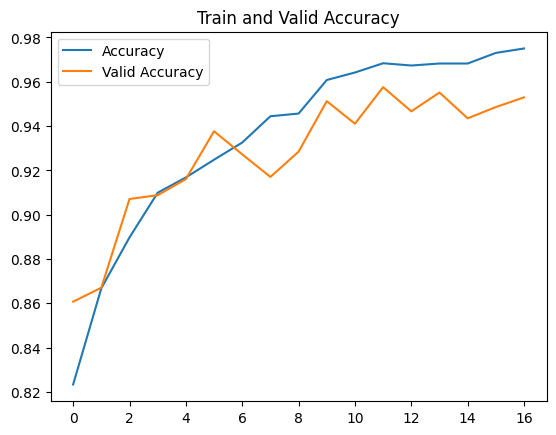

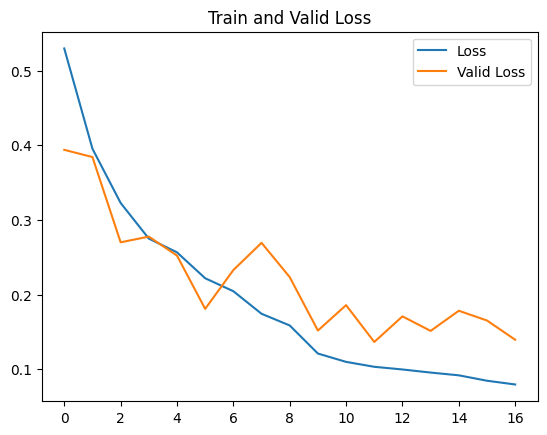

In [58]:
plt.figure()
plt.title('Train and Valid Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Valid Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend()
plt.show()

In [62]:
test_loss, test_accuracy = model_vgg19.evaluate(valid_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.9555 - loss: 0.1308
Test Loss: 0.1365
Test Accuracy: 0.9575


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


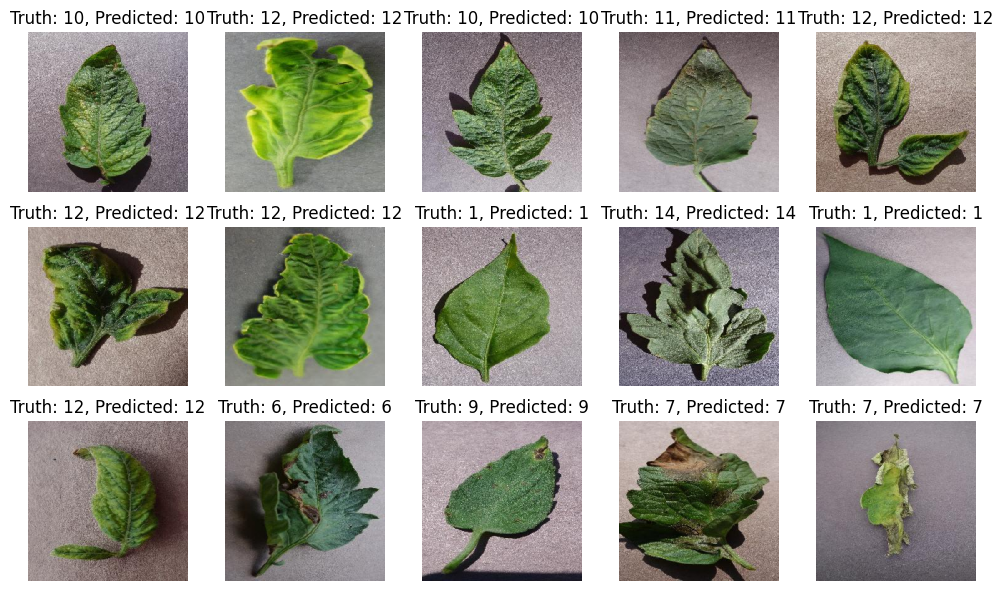

In [61]:
images, labels = next(valid_dataset)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img = images[i]
    image = img_to_array(img)
    image = tf.expand_dims(image, axis=0)
    label = np.argmax(labels[i])
    predict = model_vgg19.predict(image)[0].argmax()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Truth: {label}, Predicted: {predict}')

plt.tight_layout()
plt.show()

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get a batch of data from test_dataset
images, labels = next(valid_dataset)  # Assumes batch_size >= 20

# Take only first 20
images_200 = images[:200]
labels_200 = labels[:200]

# Predict the labels
y_pred_probs = model_vgg19.predict(images_200)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(labels_200, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


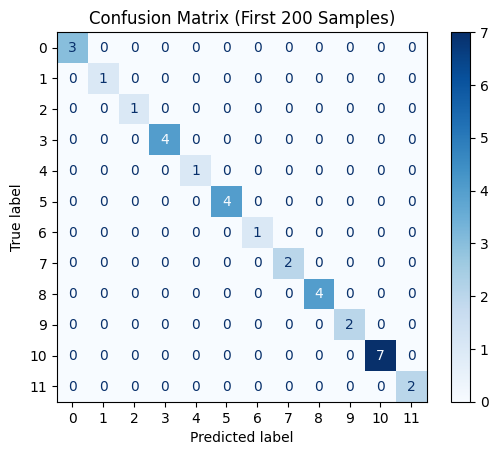

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (First 200 Samples)")
plt.show()


# ResNet152

In [79]:
from tensorflow.keras.applications import ResNet152

In [116]:
resnet_base = ResNet152(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [117]:
# Freeze all layers first
for layer in resnet_base.layers:
    layer.trainable = False

In [118]:
# Then unfreeze only layers in Conv Block 5
for layer in resnet_base.layers:
    if layer.name.startswith('conv5_'):
        layer.trainable = True


In [119]:
# Optional: Print layer trainable status
for layer in resnet_base.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")

input_layer_15: Frozen
conv1_pad: Frozen
conv1_conv: Frozen
conv1_bn: Frozen
conv1_relu: Frozen
pool1_pad: Frozen
pool1_pool: Frozen
conv2_block1_1_conv: Frozen
conv2_block1_1_bn: Frozen
conv2_block1_1_relu: Frozen
conv2_block1_2_conv: Frozen
conv2_block1_2_bn: Frozen
conv2_block1_2_relu: Frozen
conv2_block1_0_conv: Frozen
conv2_block1_3_conv: Frozen
conv2_block1_0_bn: Frozen
conv2_block1_3_bn: Frozen
conv2_block1_add: Frozen
conv2_block1_out: Frozen
conv2_block2_1_conv: Frozen
conv2_block2_1_bn: Frozen
conv2_block2_1_relu: Frozen
conv2_block2_2_conv: Frozen
conv2_block2_2_bn: Frozen
conv2_block2_2_relu: Frozen
conv2_block2_3_conv: Frozen
conv2_block2_3_bn: Frozen
conv2_block2_add: Frozen
conv2_block2_out: Frozen
conv2_block3_1_conv: Frozen
conv2_block3_1_bn: Frozen
conv2_block3_1_relu: Frozen
conv2_block3_2_conv: Frozen
conv2_block3_2_bn: Frozen
conv2_block3_2_relu: Frozen
conv2_block3_3_conv: Frozen
conv2_block3_3_bn: Frozen
conv2_block3_add: Frozen
conv2_block3_out: Frozen
conv3_blo

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout

model_resnet = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # Assuming 15 classes
])


In [121]:
model_resnet.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 7, 7, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,555,215 (227.19 MB)

 Trainable params: 16,160,271 (61.65 MB)

 Non-trainable params: 43,394,944 (165.54 MB)

In [122]:
from tensorflow.keras.optimizers import Adam

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [124]:
# Define callbacks
earlystopping2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint2 = ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)


In [125]:
history = model_resnet.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[earlystopping2, reduce_lr2, checkpoint2])

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.2971 - loss: 2.1538
Epoch 1: val_loss improved from inf to 2.02189, saving model to checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 327s 540ms/step - accuracy: 0.2972 - loss: 2.1533 - val_accuracy: 0.4277 - val_loss: 2.0219 - learning_rate: 1.0000e-04
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5042 - loss: 1.5413
Epoch 2: val_loss improved from 2.02189 to 1.90529, saving model to checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 256s 494ms/step - accuracy: 0.5042 - loss: 1.5412 - val_accuracy: 0.4207 - val_loss: 1.9053 - learning_rate: 1.0000e-04
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5606 - loss: 1.3530
Epoch 3: val_loss did not improve from 1.90529
517/517 ━━━━━━━━━━━━━━━━━━━━ 231s 447ms/step - accuracy: 0.5606 - loss: 1.3530 - val_accuracy: 0.1676 - val_loss: 5.3084 - learning_rate: 1.0000e-04
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5920 - l

In [139]:
model_resnet.save('resnet152.h5')

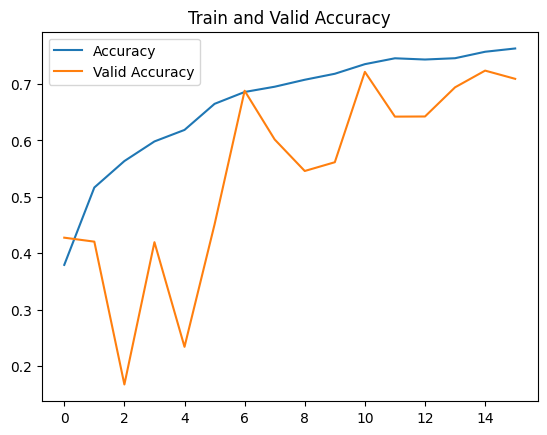

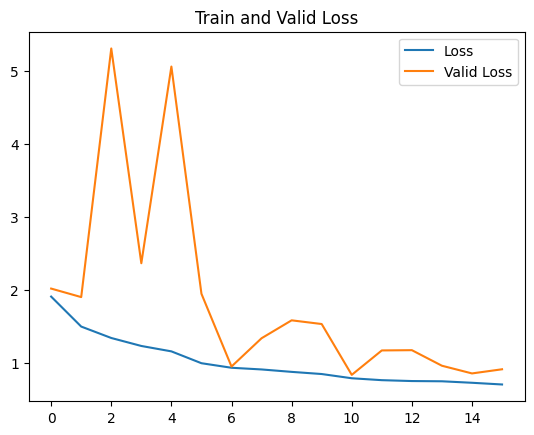

In [127]:
plt.figure()
plt.title('Train and Valid Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Valid Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend()
plt.show()

In [129]:
test_loss, test_accuracy = model_resnet.evaluate(valid_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.7241 - loss: 0.8236
Test Loss: 0.8408
Test Accuracy: 0.7215


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


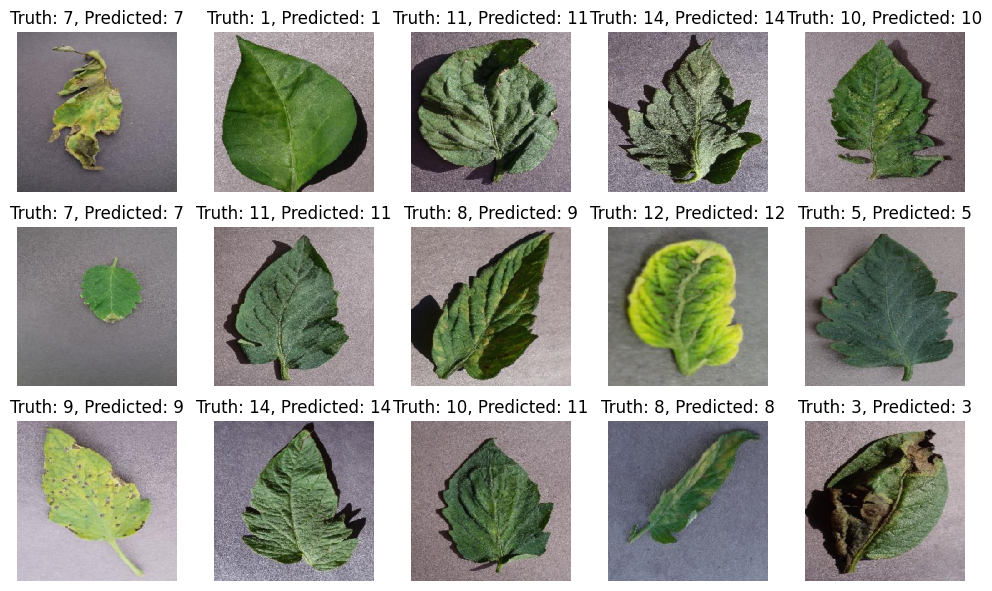

In [149]:
images, labels = next(valid_dataset)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img = images[i]
    image = img_to_array(img)
    image = tf.expand_dims(image, axis=0)
    label = np.argmax(labels[i])
    predict = model_resnet.predict(image)[0].argmax()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Truth: {label}, Predicted: {predict}')

plt.tight_layout()
plt.show()

# ResNet152 Architecture and Fine-tuning Strategy
## Base Model:
ResNet152 is a very deep residual network known for its strong feature extraction capabilities. It consists of 152 layers with skip connections that help prevent vanishing gradients.

## Pretrained Weights:
We use ImageNet pretrained weights to leverage learned low-level and mid-level visual features.

## Layer Freezing:
To avoid training the entire network (which is computationally expensive and prone to overfitting with smaller datasets), we freeze all layers except the convolutional block 5 (conv5_block) at the top of the network. This allows the model to adapt high-level features specific to the plant disease dataset while retaining general visual features learned from ImageNet.

## Classifier Head:
We add custom fully connected (dense) layers on top of the ResNet base to output predictions for 15 classes.

## Benefits: 
This approach balances efficient training time and the ability to learn domain-specific features, resulting in better generalization on our dataset.

# MobileNetV2

In [130]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [131]:
# Load base model
mobilenet_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [132]:
# Freeze all layers initially
mobilenet_base.trainable = False

# Unfreeze last convolutional block (typically 'block_16')
set_trainable = False
for layer in mobilenet_base.layers:
    if layer.name == 'block_16_depthwise':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [133]:
# Confirm layer training status
for layer in mobilenet_base.layers:
    print(layer.name, layer.trainable)

input_layer_17 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_

In [135]:
model_mobilenet = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),  # More efficient than Flatten
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # 15 classes
])


In [136]:
model_mobilenet.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,049,039 (11.63 MB)

 Trainable params: 1,521,615 (5.80 MB)

 Non-trainable params: 1,527,424 (5.83 MB)

In [137]:
# Compile
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [138]:
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint_cb = ModelCheckpoint('mobilenet_checkpoint.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model_mobilenet.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    callbacks=[earlystop_cb, reduce_lr_cb, checkpoint_cb]
)


Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5674 - loss: 1.3946
Epoch 1: val_loss improved from inf to 1.14011, saving model to mobilenet_checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 270s 493ms/step - accuracy: 0.5677 - loss: 1.3937 - val_accuracy: 0.7055 - val_loss: 1.1401 - learning_rate: 1.0000e-04
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8568 - loss: 0.4406
Epoch 2: val_loss improved from 1.14011 to 0.95396, saving model to mobilenet_checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 206s 398ms/step - accuracy: 0.8568 - loss: 0.4405 - val_accuracy: 0.7535 - val_loss: 0.9540 - learning_rate: 1.0000e-04
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8933 - loss: 0.3216
Epoch 3: val_loss improved from 0.95396 to 0.90473, saving model to mobilenet_checkpoint.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 202s 390ms/step - accuracy: 0.8933 - loss: 0.3216 - val_accuracy: 0.7688 - val_loss: 0.9047 - learning_rate: 1.0000e-04
Epoch 4/

In [140]:
model_mobilenet.save('mobilenetV2.h5')

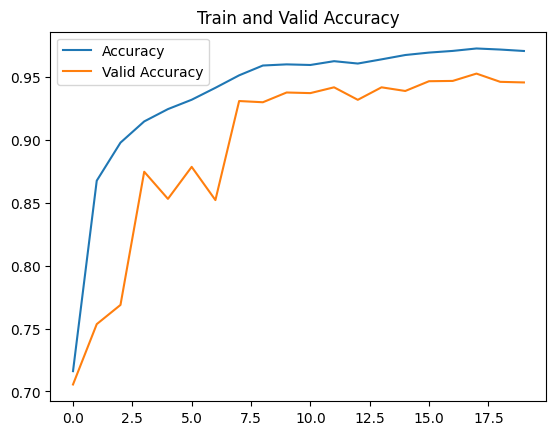

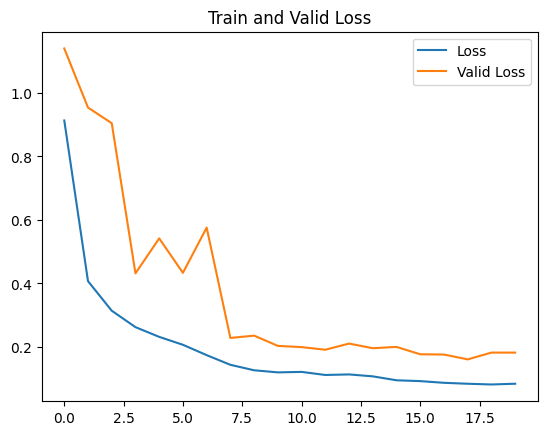

In [141]:
plt.figure()
plt.title('Train and Valid Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Valid Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend()
plt.show()

In [146]:
test_loss,test_accuracy= model_mobilenet.evaluate(valid_dataset, verbose=1)
print(f"Test loss:{test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9578 - loss: 0.1470
Test loss:0.1606
Test Accuracy: 0.9529


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


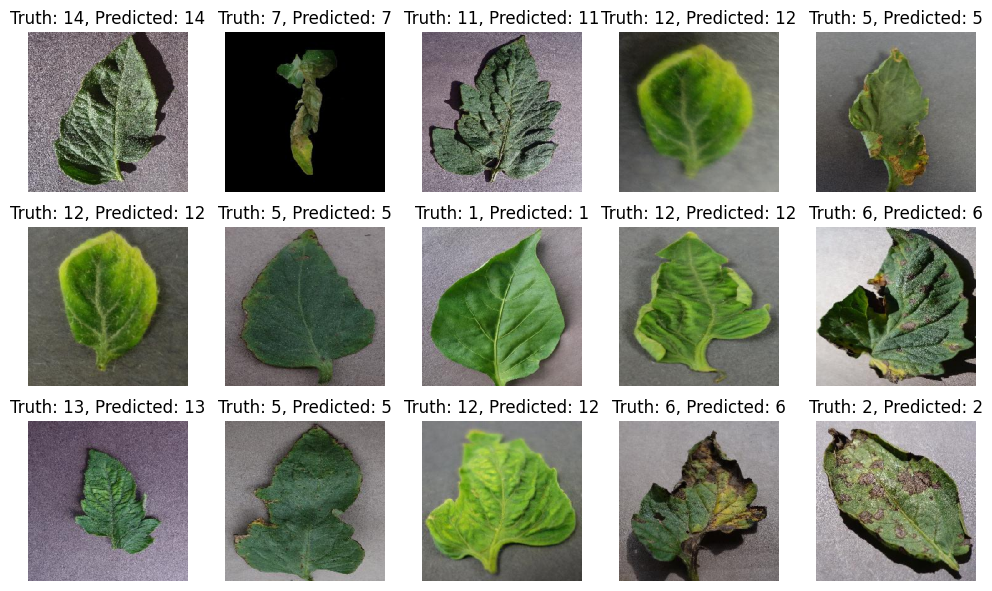

In [148]:
images, labels = next(valid_dataset)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img = images[i]
    image = img_to_array(img)
    image = tf.expand_dims(image, axis=0)
    label = np.argmax(labels[i])
    predict = model_mobilenet.predict(image)[0].argmax()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Truth: {label}, Predicted: {predict}')

plt.tight_layout()
plt.show()

# MobileNetV2 Architecture and Fine-tuning Strategy
## Base Model: 
MobileNetV2 is a lightweight convolutional neural network designed for efficient mobile and embedded vision applications, using inverted residuals and linear bottlenecks.

## Pretrained Weights:
We load ImageNet weights to utilize well-trained feature detectors.

## Layer Freezing: 
Since MobileNetV2 is smaller and designed to be efficient, we freeze the majority of its layers and fine-tune only the last convolutional block (block_16). This targets learning high-level features relevant to our plant disease classification task without overfitting or requiring excessive computation.

## Classifier Head:
Similar to ResNet152, a global average pooling layer followed by dense layers is added to transform extracted features into class probabilities for the 15 plant disease categories.

## Benefits:
This model is faster to train and lighter in size, suitable when resources are limited or quick experimentation is needed while still maintaining good accuracy through selective fine-tuning.

